In [1]:
from PyPDF2 import PdfFileWriter, PdfFileReader
import string
from collections import Counter
from tqdm import tqdm

def add_wordcount_to_dict(words_from_page, total_word_count):
    '''Update the count of total words within the text'''
    for key in words_from_page.keys():
        if key not in total_word_count.keys():
            total_word_count[key] = words_from_page[key]
        else:
            total_word_count[key] += words_from_page[key]
    

# output = PdfFileWriter()
input1 = PdfFileReader(open("domCasmurro.pdf", "rb"))
text_file = open("book_content.txt", "w", encoding='utf-8')


total_word_count = dict()

totalNumPages = input1.numPages

for page in tqdm(range(totalNumPages)):
    #extrai o texto de uma página
    page_text = input1.getPage(page).extractText()
    text_file.write(page_text)
    #remove '\n' e pontuações
    page_content = page_text.lower().replace('\n', '').translate(str.maketrans('', '', string.punctuation)).split(' ')
    dict_words_page = Counter(page_content)
    add_wordcount_to_dict(dict_words_page, total_word_count)

100%|██████████| 128/128 [00:03<00:00, 34.60it/s]


In [2]:
written_file= open("book_content.txt", "r")
read_written = written_file.read()

In [3]:
import operator
import nltk
from nltk.corpus import stopwords
total_word_count
sorted_words = sorted(total_word_count.items(), key=operator.itemgetter(1), reverse=True)
# map(total_word_count.pop, ['a','c'])
# nltk.Text(read_written)
type(read_written)

str

In [4]:
sw = stopwords.words('portuguese')
tokens = nltk.word_tokenize(read_written.lower())
tokens = [token  for token in tokens if token.isalpha() and token not in sw]
text = nltk.Text(tokens)

In [5]:
text.collocations()

josé dias; prima justina; tio cosme; pode ser; padre cabral; outra
vez; alguma coisa; alguns instantes; outra coisa; dia seguinte; muita
vez; engenho novo; ser padre; rio janeiro; protonotário apostólico;
mana glória; dom casmurro; sala visitas; santa mônica; santos óleos


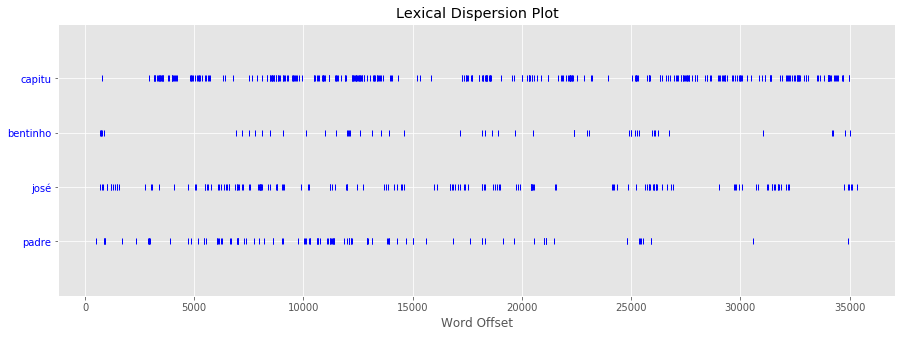

<Figure size 432x288 with 0 Axes>

In [6]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")
plt.figure(figsize=(15,5))
plt.ion()
text.dispersion_plot(["capitu", "bentinho", "josé", "padre"])
plt.savefig("dispersion.png")
plt.ioff()
plt.show()

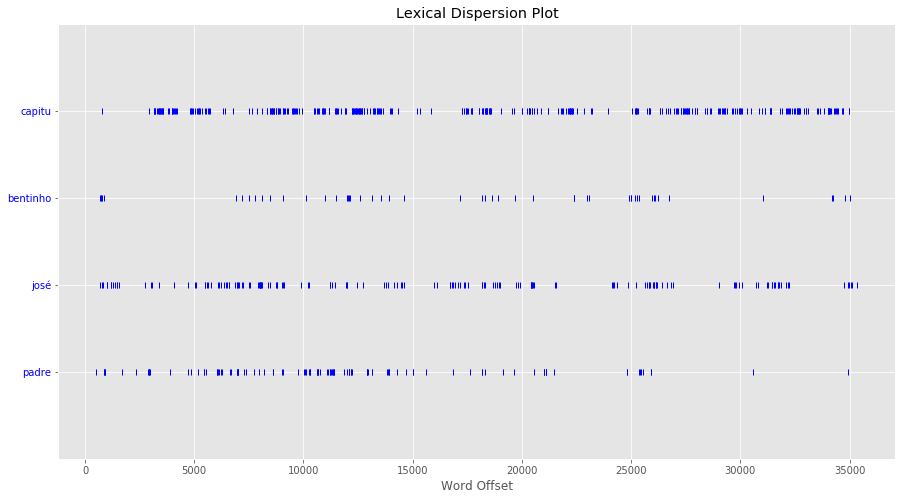

In [43]:
def dispersion_plot(text, words, ignore_case=False, title="Lexical Dispersion Plot"):
    """
    Generate a lexical dispersion plot.

    :param text: The source text
    :type text: list(str) or enum(str)
    :param words: The target words
    :type words: list of str
    :param ignore_case: flag to set if case should be ignored when searching text
    :type ignore_case: bool
    """

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        raise ValueError(
            'The plot function requires matplotlib to be installed.'
            'See http://matplotlib.org/'
        )

    text = list(text)
    words.reverse()

    if ignore_case:
        words_to_comp = list(map(str.lower, words))
        text_to_comp = list(map(str.lower, text))
    else:
        words_to_comp = words
        text_to_comp = text

    points = [
        (x, y)
        for x in range(len(text_to_comp))
        for y in range(len(words_to_comp))
        if text_to_comp[x] == words_to_comp[y]
    ]

    if points:
        x, y = list(zip(*points))
    else:
        x = y = ()
    fig = plt.figure(figsize = (15,8))
    plt.plot(x, y, "b|", scalex=0.1)
#     sb.stripplot(x, y)
    plt.yticks(list(range(len(words))), words, color="b")
    plt.ylim(-1, len(words))
    plt.title(title)
    plt.xlabel("Word Offset")
    plt.show()
    fig.savefig("lexical_dispersion.jpg")
    
    return points
    
words = ["capitu", "bentinho", "josé", "padre"]
points = dispersion_plot(text, words)

(-1, 4)

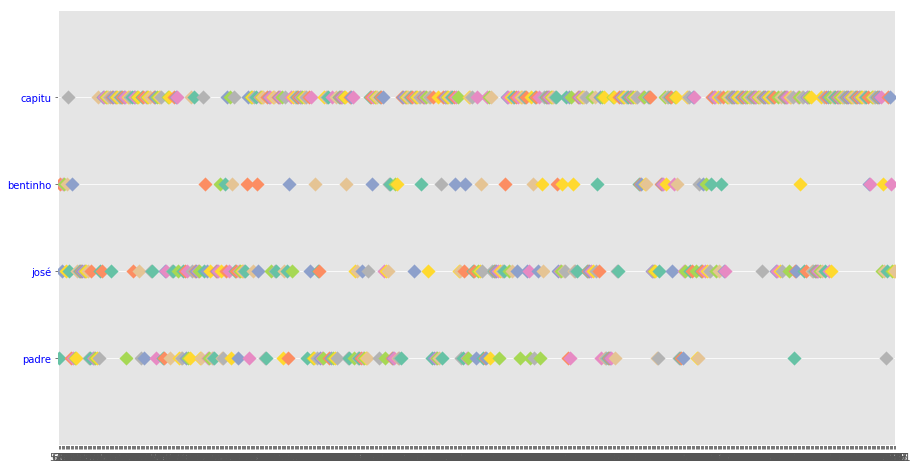

In [37]:
import pandas as pd
x = list()
y = list()
for x_p,y_p in points:
    y.append(y_p)
    x.append(x_p)
    
df = pd.DataFrame.from_dict({'x':x, 'y': y})
df.set_index('y')
plt.figure(figsize = (15,8))
sb.stripplot(x, y, data = df, palette = 'Set2', size = 10, marker = 'D')
plt.yticks(list(range(len(words))), words, color="b")
plt.ylim(-1, len(words))

In [7]:
def ttr(text):
    '''
    Lexical diversity measured by Type-Token Ratio, measured using the number of unique words 
    and the total number of words in the whole text
    
    This kind of measure is bad to compare texts of different lengths.
    For details see here https://en.wikipedia.org/wiki/Lexical_diversity
    '''
    return round(len(set(text))/len(text),2)

ttr(text)

0.25

In [8]:
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit

####################
#### Parameters ####
####################
N_SUBSAMPLES = 100
sample_range = range(100,500,25)


def select_random_subsample(text_from_tokens, sample_size):
    return np.random.choice(np.array(text_from_tokens), size = sample_size, replace = False)

def ttr_subsample(tokens):
    return len(set(tokens))/len(tokens)

def TTR_function(x, D):
    return np.multiply((D/x),((1+2*x/D)**(1/2) - 1), dtype = np.float)

def compute_D(text_from_tokens):
    '''
    This algorithm was implemented based on page 328 of the following paper:
    https://www.researchgate.net/publication/283149921_Measuring_Vocabulary_Diversity_Using_Dedicated_Software
    '''
    best_fit_ds = list()
    best_fit_ds_std = list()

    for i in range(0,3):
        ttr_step_list = list()
        std_ttr_step_list = list()
        D_sample = list()

        for N in tqdm(sample_range):
            ttr_sample_list = list()

            for i in range(N_SUBSAMPLES):
                random_tokens = select_random_subsample(text_from_tokens, N)
                ttr = ttr_subsample(random_tokens)
                ttr_sample_list.append(ttr)

            ttr_sample_list = np.array(ttr_sample_list)
            mean_ttr = ttr_sample_list.mean()        
            std_ttr = ttr_sample_list.std()
            ttr_step_list.append(mean_ttr); std_ttr_step_list.append(std_ttr)

            D = - N*(mean_ttr**2)/(2*(mean_ttr - 1))
            D_sample.append(D)

        D_avg = np.array(D_sample).mean()
        D_std = np.array(D_sample).std()
        best_D_fit, best_D_std = curve_fit(TTR_function, xdata = np.array(sample_range), ydata = np.array(ttr_step_list))
        best_fit_ds.append(best_D_fit)
        best_fit_ds_std.append(best_D_std)
        
    best_fit_ds = np.array(best_fit_ds)
    best_fit_ds_std = np.array(best_fit_ds_std)
    
    return best_fit_ds.mean(), best_fit_ds_std.mean() 

d, std_d = compute_D(text) # D is known as vocabulary diversity

100%|██████████| 16/16 [01:14<00:00,  4.44s/it]


In [20]:
points

NameError: name 'points' is not defined

In [9]:
d, std_d

(803.4049785354201, 242.98428513463372)

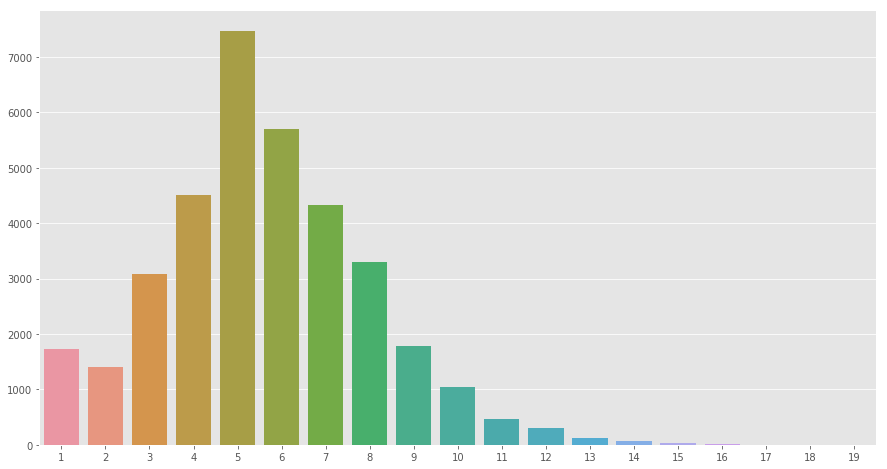

In [44]:
# count the number of words
from collections import defaultdict
import seaborn as sb

def count_words(text):
    length_count =  defaultdict(int)

    for word in text:
        number_of_chars = len(word)
        length_count[number_of_chars]+=1

    fig = plt.figure(figsize=(15,8))
    sb.barplot(x = list(length_count.keys()), y = list(length_count.values()));
    fig.savefig("length_count.jpg")
    return length_count

_ = count_words(text)

In [11]:
# average phrase length

#tokens with punctuation
tokens_w_punc = nltk.word_tokenize(read_written.lower())

end_of_sentences = list()
for index, word in enumerate(tokens_w_punc):
    if word == "." or word == "!" or word == "?":
        end_of_sentences.append(index)
        
# since end_of_sentences gives the index for the end of each sentence, 
# counting the number of indicies between them will give the number of
# words in a given sentence. This way we can plot the distribution of word count
# in all phrases along the text
plt.figure(figsize=(30,15))
sb.countplot(np.diff(end_of_sentences));

def 

SyntaxError: invalid syntax (<ipython-input-11-bfef1be9d8ee>, line 18)

In [ ]:
# number of sentences in the document
len(np.diff(end_of_sentences))

In [ ]:
sw = stopwords.words('portuguese')
frequency = nltk.FreqDist(w.lower() for w in tokens if w not in sw)

In [ ]:
frequency

In [ ]:
# frequency.pop(',')
# frequency.pop('.')
frequency.pop('š')
# frequency.pop('?')
frequency.pop('é')
# frequency.pop('!')
# frequency.pop(';')
# frequency.pop('...')
# frequency.pop(':')
# frequency.pop('a')

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(stopwords = set(sw), background_color='white', contour_color='black', random_state=5, height=500, width=700).generate(read_written)
plt.figure(figsize=(10,20))
plt.imshow(wc)
wc.to_file('wordcloud.jpg')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sb
from collections import Counter
plt.style.use('ggplot')
%matplotlib inline

k = Counter(frequency)
top_k = {}
for word, value in k.most_common(20):
    top_k[word] = value

plt.figure(figsize=(15,5))
plt.bar(range(len(top_k)), list(top_k.values()), align='center')
plt.xticks(range(len(top_k)), list(top_k.keys()), rotation = 'vertical')
plt.show()

In [ ]:
def freq_plot(word_frequency, top_words = 20):
    # Compute the most frequent words and sort them in descending order 
    k = Counter(word_frequency)
#     k.most_common(top_words)
    top_k = {}
    for word, value in k.most_common(top_words):
        top_k[word] = value

    # Bar plot
    fig = plt.figure(figsize=(15,5))
    plt.bar(range(len(top_k)), list(top_k.values()), align='center')
    plt.xticks(range(len(top_k)), list(top_k.keys()), rotation = 'vertical')
    plt.xlabel("Words", fontsize = 15)
    plt.ylabel("Frequency", fontsize = 15)
    plt.title(f"Word Frequency for the top {top_words} words", fontsize = 25)
    plt.show() 
    
    return 0

In [ ]:
freq_plot(frequency)

In [ ]:
from scipy.optimize import curve_fit

def func(x, D):
    return np.multiply((D/x),((1+2*x/D)**(1/2) - 1), dtype = np.float)

# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c

n = np.array([N for N in range(35,50)])
noise = 0.0015*np.random.normal(size = n.shape)
mean_ttr = func(n, D = 50) + noise

# D = - N*(mean_ttr**2)/(2*(mean_ttr - 1))
plt.scatter(y = mean_ttr,x =  n)

params, _ = curve_fit(func ,xdata = n,ydata= mean_ttr)
# func(n, 100)
# mean_ttr
params